In [1]:
!pip install cudaq==0.11.0 rdkit==2025.3.3 pandas==2.3.1 -q
# 安裝完請重新啟動執行階段後再繼續執行下方匯入步驟


In [ ]:
!wget -q https://raw.githubusercontent.com/Ashur5457/CUDA-Q/main/TWCC/latest/util_qmg.py -O util_qmg.py
# 下載 util_qmg.py 以供後續匯入，若檔案已存在會被更新


# **CUDA-Q for Quantum-Based Molecule Generation**

Overview of the quantum-based molecular generator (QMG) construction process. a. The dynamic quantum circuit ansatz has multiple parameterized singe-qubit and controlled rotation gates. A scaffold-retained generation scheme allows specific gate parameters to be fixed, ensuring the presence of desired functional groups or substructures. The measured output is then reassembled into valid 2D molecular graphs with stereochemical details, and Bayesian optimization (BO) refines the circuit parameters to optimize the objective functions. b. An illustration figure of 3-heavy atom QMG with a total of 6 qubits. This circuit demonstrates the qubit reuse technique and dynamic operations based on mid-circuit measurement outcomes (purple box).  
<img src="./images/QMG_Figure_1.svg" width="1000" />

For detailed studies, please refer to the following paper: Chen, L. Y., Li, T. Y., Li, Y. P., Chen, N. Y., & You, F. (2025). Exploring Chemical Space with Chemistry-Inspired Dynamic Quantum Circuits in the NISQ Era. ***Journal of Chemical Theory and Computation***. https://pubs.acs.org/doi/full/10.1021/acs.jctc.5c00305

---

## 1. Introduction of dynamic quantum circuit for molecular generator
<img src="./images/QMG_Figure_2.svg" width="1000" />

## 2. Quantum-Based Molecule Generation for 3 Heavy Atoms

### Preparation

In [2]:
# 匯入 CUDA-Q 以及自訂的量子分子工具
import cudaq
from cudaq import ry, mz, x
from util_qmg import MoleculeQuantumStateGenerator, draw_top_molecules
import random
import numpy as np
import itertools

### Setup and Create weight parameters

In [3]:
# 設定原子與鍵的位元長度與權重配置
num_heavy_atom = 10  # 預設支援最多十個重元素，可放入苯、吡啶、簡單稠環
atom_selection_bits = 7
bond_selection_bits = 3
atom_weight_config = {
    "C": 25,
    "N": 25,
    "O": 25,
    "S": 5,
    "P": 5,
    "F": 5,
    "Cl": 5,
    "Br": 5,
    "I": 5,
}

def enumerate_bond_pairs(num_atoms: int):
    """
    以上三角編號方式列出所有鍵的原子配對，對應到位元塊索引。
    """
    pairs = []
    for i in range(num_atoms - 1):
        for j in range(i + 1, num_atoms):
            pairs.append((i, j))
    return pairs

def build_ring_templates(num_atoms: int, pairs):
    """
    建立所有 5/6 員環以及簡單稠環的邊集合，以便在 Kernel 內加入關聯操作。
    """
    if num_atoms < 5:
        return []
    index_map = {tuple(pair): idx for idx, pair in enumerate(pairs)}
    simple_rings = []
    templates = set()
    for ring_size in (5, 6):
        if num_atoms < ring_size:
            continue
        for combo in itertools.combinations(range(num_atoms), ring_size):
            cycle = list(combo)
            edges = []
            for offset in range(ring_size):
                a = cycle[offset]
                b = cycle[(offset + 1) % ring_size]
                key = (a, b) if a < b else (b, a)
                edge_idx = index_map[key]
                edges.append(edge_idx)
            normalized = tuple(sorted(set(edges)))
            simple_rings.append((set(combo), normalized))
            templates.add(normalized)
    fused = set()
    for idx_a, (nodes_a, edges_a) in enumerate(simple_rings):
        for nodes_b, edges_b in simple_rings[idx_a + 1 :]:
            if len(nodes_a & nodes_b) >= 2:
                fused.add(tuple(sorted(set(edges_a) | set(edges_b))))
    templates.update(fused)
    return [list(t) for t in templates]

bond_pairs = enumerate_bond_pairs(num_heavy_atom)
ring_edge_sets = build_ring_templates(num_heavy_atom, bond_pairs)
num_bonds = len(bond_pairs)
num_ring_templates = len(ring_edge_sets)
length_all_weight_vector = (
    num_heavy_atom * atom_selection_bits
    + num_bonds * bond_selection_bits
    + num_ring_templates
)
ring_bond_index_set = {idx for ring in ring_edge_sets for idx in ring}
random.seed(10)


In [4]:
# 初始化量子參數向量，針對原子、鍵與環偏壓分段處理
all_weight_vector = np.array([random.random() for _ in range(length_all_weight_vector)])
atom_param_count = num_heavy_atom * atom_selection_bits
all_weight_vector[:atom_param_count] = 0.5

if num_bonds:
    bond_param_start = atom_param_count
    bond_param_end = bond_param_start + num_bonds * bond_selection_bits
    bond_params = all_weight_vector[bond_param_start:bond_param_end]
    bond_params = np.clip(bond_params, 0.2, 0.8)
    all_weight_vector[bond_param_start:bond_param_end] = bond_params

ring_param_start = atom_param_count + num_bonds * bond_selection_bits
if num_ring_templates:
    ring_bias = np.full(num_ring_templates, 0.85)
    all_weight_vector[ring_param_start:] = ring_bias


In [5]:
all_weight_vector

array([0.57140259, 0.42888905, 0.5780913 , 0.20609823, 0.81332125,
       0.82358887, 0.65347253, 0.16022956, 0.52066936, 0.32777281,
       0.24999668, 0.44554178, 0.55445822, 0.02227819, 0.93008052,
       0.30159531, 0.69080299])

### Build Quantum-Based Molecule Generation(QMG) Kermel

In [6]:
# 定義量測位元對應九種重元素的 CUDA-Q kernel
@cudaq.kernel
def QMG_kernel(weight_vector: list[float]):
    num_atoms = num_heavy_atom
    total_atom_params = num_atoms * atom_selection_bits
    num_bonds = len(bond_pairs)
    total_bond_params = num_bonds * bond_selection_bits
    total_qubits = total_atom_params + total_bond_params
    q = cudaq.qvector(total_qubits)

    param_idx = 0
    # 先為原子位元執行旋轉，維持重元素機率配置
    for atom_idx in range(num_atoms):
        start = atom_idx * atom_selection_bits
        for bit in range(atom_selection_bits):
            ry(np.pi * weight_vector[param_idx], q[start + bit])
            param_idx += 1

    bond_offset = total_atom_params
    bond_block_starts = []
    for bond_idx in range(num_bonds):
        block_start = bond_offset + bond_idx * bond_selection_bits
        bond_block_starts.append(block_start)
        for bit in range(bond_selection_bits):
            ry(np.pi * weight_vector[param_idx], q[block_start + bit])
            param_idx += 1

    # 使用額外參數偏壓各環的首位元並加入受控 CNOT 鏈，提高閉環鍵同時出現的機率
    for ring_edges in ring_edge_sets:
        if not ring_edges:
            continue
        pivot_start = bond_block_starts[ring_edges[0]]
        pivot_qubit = pivot_start
        ry(np.pi * weight_vector[param_idx], q[pivot_qubit])
        param_idx += 1
        for edge_idx in ring_edges[1:]:
            target_qubit = bond_block_starts[edge_idx]
            x.ctrl(q[pivot_qubit], q[target_qubit])

    # 將原子與鍵的位元集中送進測量暫存器
    for atom_idx in range(num_atoms):
        start = atom_idx * atom_selection_bits
        mz(q[start:start + atom_selection_bits], register_name='qmg_result')

    for bond_idx in range(num_bonds):
        start = bond_block_starts[bond_idx]
        mz(q[start:start + bond_selection_bits], register_name='qmg_result')


### Sample and Draw the top molecules

In [7]:
# 在 QPP 模擬器上先跑少量取樣作為檢查
num_sample = 1000
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)
qmg_counts = result.get_register_counts('qmg_result')
print("QMG Counts:", qmg_counts)

QMG Counts: { 010000000000:330 010101000000:3 010101010000:1 010101100101:2 010101110000:3 010110000000:12 010110010000:1 010110010001:1 010110010100:1 010110100000:2 010110100001:1 010110100100:1 010110100101:1 010110110000:3 010110110001:4 010110110010:2 010111000000:1 010111110101:1 011001000000:2 011001100001:1 011001110000:1 011001110001:1 011001110010:1 011010000000:5 011010010001:1 011010010101:1 011010010111:1 011010100100:1 011010110000:2 011010110001:2 011010110101:3 011011110001:1 011011110100:1 011101000000:1 011101110101:1 011110000000:2 011110010010:1 011110010101:1 011110100000:2 011110100001:1 011110110000:1 011110110001:1 011110110101:1 011111110000:1 100000000000:16 100101000000:12 100101010000:2 100101010001:1 100101010101:1 100101100000:1 100101100001:5 100101100010:1 100101100101:2 100101100110:1 100101110000:3 100101110001:5 100101110010:1 100101110100:1 100110000000:31 100110010000:2 100110010001:3 100110010101:3 100110010110:1 100110100000:2 100110100001:3 10011

In [8]:
# 將量測結果轉回分子結構並統計有效性
data_generator = MoleculeQuantumStateGenerator(
    heavy_atom_size=num_heavy_atom,
    ncpus=1,
    sanitize_method="strict",
    atom_weights=atom_weight_config,
    atom_selection_bits=atom_selection_bits,
)

smiles_dict = {}
num_valid_molecule = 0
for key, value in qmg_counts.items():
    key = key[::-1]
    key = "".join(key.split())
    smiles = data_generator.QuantumStateToSmiles(data_generator.post_process_quantum_state(key))
    smiles_dict[smiles] = smiles_dict.get(smiles, 0) + value
    if smiles:
        num_valid_molecule += value
validity = (num_valid_molecule) / num_sample
uniqueness = (len(smiles_dict.keys()) - 1) / num_valid_molecule
smiles_dict, validity, uniqueness

print(smiles_dict)
print("Validity: {:.2f}%".format(validity*100))
print("Uniqueness: {:.2f}%".format(uniqueness*100))


{None: 123, 'C=CC': 2, 'N.N=N': 1, 'CN': 3, '[N-]=[N+]=N': 1, 'C.CC': 1, 'C=N.N': 2, 'CON': 4, 'N=CO': 1, 'C=N.O': 3, 'C1=NN1': 1, 'C.N=O': 6, 'NOO': 3, 'NCN': 1, 'CN=O': 7, 'N=O.O': 12, 'O=NO': 10, 'N=NN': 3, 'C.C=C': 1, '[nH]1oo1': 3, 'O=CO': 5, 'C=O': 36, 'C=NN': 1, 'N=O': 73, 'CO': 14, 'OCO': 5, 'C=N': 5, 'C#[N+][O-]': 2, 'C1=CO1': 1, 'NO.O': 2, 'C1NN1': 1, 'N.NO': 7, 'O=C=O': 3, 'C=CO': 2, 'CC': 3, 'C=O.N': 7, 'O': 16, 'N1=NO1': 2, 'C=NO': 1, 'N=N': 6, 'CC=O': 3, 'N.NN': 1, 'NN=O': 20, 'NN': 4, 'N.N=O': 16, 'NO': 33, 'N': 120, 'C': 330, 'CC.N': 3, 'C1CO1': 3, 'COO': 1, 'C#C': 1, 'CO.N': 4, 'NC=O': 10, 'C=C': 12, 'C.C=O': 2, 'C=C.N': 3, '[nH]1[nH]o1': 4, 'C.CO': 2, 'NCO': 5, 'C#N.N': 1, 'N=NO': 1, 'C1=NC1': 2, 'ONO': 3, 'N1=NN1': 1, 'C=C=N': 2, 'NNN': 1, 'C.NO': 2, 'NNO': 5, 'C.C=N': 2, 'NON': 4, 'CNO': 1, 'CCO': 1, 'C1#CN1': 1, 'N=C=O': 1, 'CO.O': 1, 'N=CN': 4, 'C=O.O': 2, 'C=CN': 4, 'C1OO1': 2, 'C=C.O': 2}
Validity: 87.70%
Uniqueness: 9.12%


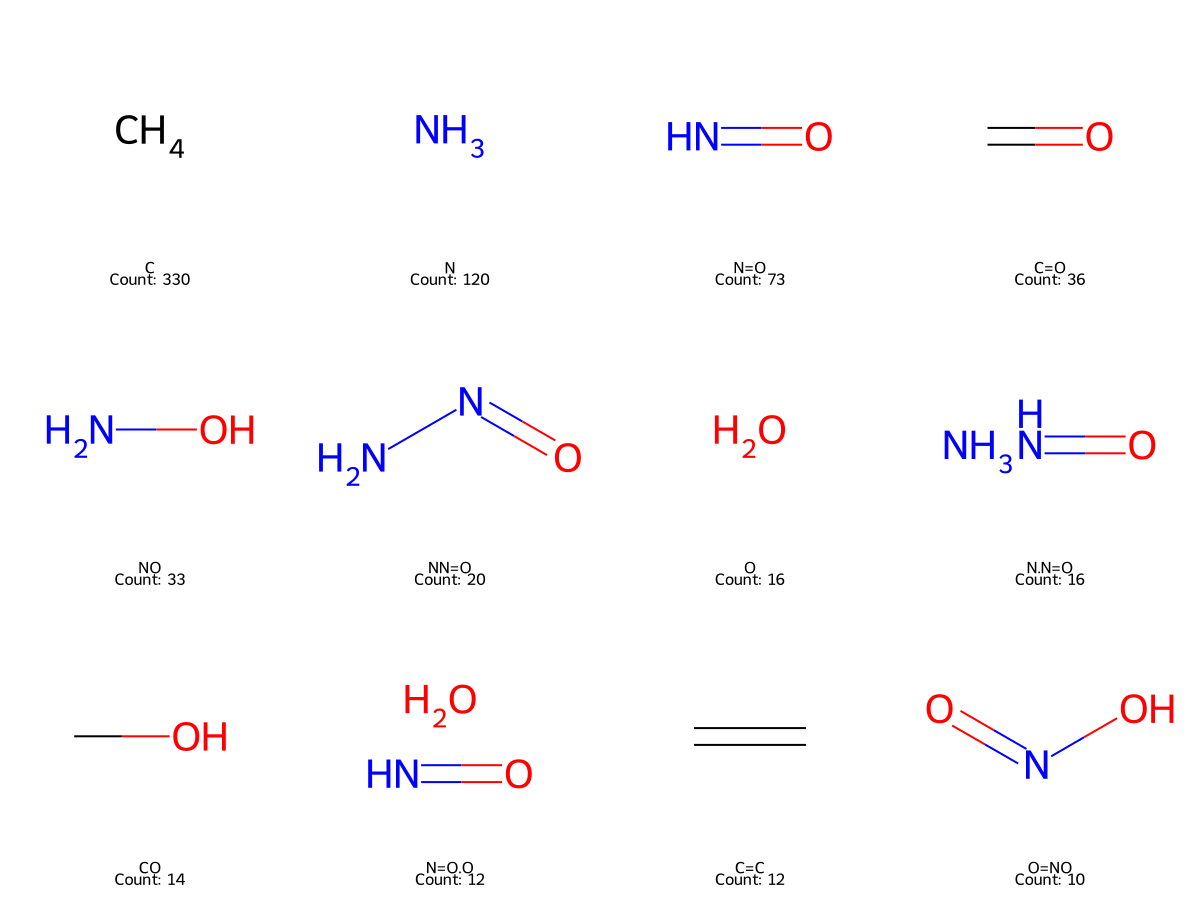

In [9]:
# 以網格繪出出現頻率最高的分子
draw_top_molecules(smiles_dict, top_n=12, mols_per_row=4)

## 3. Backend Comparison

In [10]:
# 擴大量測次數以比對不同後端效能
num_sample = 10000

- StateVector Simulation(CPU)

In [11]:
# 切換到 CPU 模擬後端作為基準
cudaq.set_target('qpp-cpu')

In [12]:
# 測量目前後端的取樣時間
%%time
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)

CPU times: user 26.1 s, sys: 238 ms, total: 26.4 s
Wall time: 6.61 s


- StateVector Simulation(GPU)

In [13]:
# 切換至 NVIDIA GPU 後端 (需 L4 GPU)
cudaq.set_target('nvidia')

In [14]:
# 測量目前後端的取樣時間
%%time
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)

CPU times: user 14.6 s, sys: 1.36 s, total: 15.9 s
Wall time: 16 s
